# Asymptotic formulae of profile-likelihood-ratio-based test statistics

## Recap

### Data model

We have been working with a probability model and likelihood function for a simple one bin counting experiment with $n$ observed, $s$ expected signal, and $b$ expected background events in our signal region and $m$ observed and $b$ expected background events, in our control region, with the signal strength parametrized by $\mu$:

$$
P(n, m; \mu s, b) = \frac{(\mu s+b)^n e^{-(\mu s+b)}}{n!} \cdot \frac{b^m e^{-b}}{m!} = L(
\mu, b),
$$ (6model)

The negative-log-likelihood (NLL) is:

```{math}
:label: 6nll
-\ln L \equiv -l = \ln n! + \ln m! + \mu s + 2b - n\ln(\mu s+b) - m \ln b
```

### Test statistics

In Parts 1 - 4, we introduced the profile likelihood ratio test statistic,

$$
\lambda(\mu) = \frac{L(\mu, \hat{\hat{b}}(\mu))}{L(\hat{\mu}, \hat{b})}, \quad t_\mu=-2\ln \lambda(\mu),
$$ (6ts)

the alternate statistic for positive-only signals,

$$
\tilde{\lambda}(\mu) = \left\{
    \begin{array}{ll}
      \frac{L(\mu, \hat{\hat{b}}(\mu))}{L(\hat{\mu}, \hat{b})}, & \mbox{$\hat{\mu}\geq0$}.\\
      \frac{L(\mu, \hat{\hat{b}}(\mu))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{\mu}<0$}.
    \end{array}
  \right., \quad \tilde{t}_\mu=-2\ln \tilde{\lambda}(\mu) = -2[l(\mu, \hat{\hat{b}}(\mu)) - l(\hat{\mu}, \hat{b})],
$$ (6ts_tilde)

and the test statistic for setting upper limits,

$$
    \tilde{q}(\mu) = \left\{
      \begin{array}{ll}
        \tilde{t}(\mu), & \mbox{$\hat{\mu} < \mu$}.\\
        0, & \mbox{$\hat{\mu} \geq \mu$}.
      \end{array}
    \right.
    = \left\{
    \begin{array}{ll}
        -2\ln\frac{L(\mu, \hat{\hat{b}}(\mu))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{\mu}<0$}.\\
        -2\ln\frac{L(\mu, \hat{\hat{b}}(\mu))}{L(\hat{\mu}, \hat{b})}, & \mbox{0 $\leq \hat{\mu} < \mu$}.\\
        0, & \mbox{$\hat{\mu} \geq \mu$}.
      \end{array}
    \right.
$$ (6qs_tilde)

We also showed how to derive observed and expected signal significances and upper limits, which required the sampling distributions of the test statistics under different signal hypotheses $H_{\mu'}$: $p(t(\mu)|\mu')$ etc., for both $\mu' = \mu$ *and* $\mu' \neq \mu$.
So far, we have always estimated these by generating pseudodatasets / toy experiments sampled from our data model Eq. {eq}`6model` under $H_{\mu'}$.

### Asymptotic form of the MLE

As the toy-based approach of estimating these sampling distributions can be computationally intractable for complex models, in the previous part, we discussed the use of asymptotic - in the large-sample limit - approximations of these distributions instead.
To do so, we started by deriving the asymptotic form of the maximum likelihood estimator (MLE) $\hat\mu$ of $\mu$:

$$
    \hat\mu \simeq \mathcal N(\mu', \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')}),
$$ (6asym_std_fisher)

where $\mu'$ is the true signal strength, and $\mathcal I(\mu', b')$ is the Fisher information, or covariance, matrix 

$$
    \mathcal I_{ij}(\mu', b') = - \mathbb E [\frac{\partial^2 l(\mu', b')}{\partial \mu_i \partial \mu_j}]
$$ (6fisher_matrix)

The asymptotic form is correct up to terms of order $\mathcal O(\frac{1}{\sqrt{N}})$, where $N$ represents the data sample size.

Code from previous parts:

In [1]:
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, chi2, ncx2
import warnings
from IPython.display import display, Latex

plt.rcParams.update({"font.size": 16})
warnings.filterwarnings("ignore")

In [2]:
def log_poisson_nofactorial(n, mu):
    return -mu + n * np.log(mu)


def log_likelihood_nofactorial(s, b, n, m):
    return log_poisson_nofactorial(n, s + b) + log_poisson_nofactorial(m, b)


def shat(n, m):
    return n - m


def bhat(n, m):
    return m


def bhathat(s, n, m):
    """Using the quadratic formula and only the positive solution"""
    return ((n + m - 2 * s) + np.sqrt((n + m - 2 * s) ** 2 + 8 * s * m)) / 4


def t_s(s, n, m):
    """-2ln(lambda))"""
    bhh, bh = bhathat(s, n, m), bhat(n, m)
    return -2 * (
        log_likelihood_nofactorial(s, bhh, n, m) - log_likelihood_nofactorial(shat(n, m), bh, n, m)
    )


def t_zero_s(s, n, m):
    """Alternative test statistic when shat < 0"""
    return -2 * (
        log_likelihood_nofactorial(s, bhathat(s, n, m), n, m)
        - log_likelihood_nofactorial(0, bhathat(0, n, m), n, m)
    )


def t_tilde_s(s, n, m):
    #     s, n, m = [np.array(x) for x in (s, n, m)]  # convert to numpy arrays
    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    ts = np.array(t_s(s, n, m))
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]
    return ts.squeeze()


def q_tilde_s(s, n, m):
    ts = np.array(t_s(s, n, m))

    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]

    upper_shat_mask = shat(n, m) > s
    ts[upper_shat_mask] = 0

    return ts.squeeze()

In [3]:
def get_toys_sb(s, b, num_toys):
    """Generate toy data for a given s and b"""
    # sample n, m according to our data model (Eq. 1)
    n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
    return n, m


def get_toys(s, n_obs, m_obs, num_toys):
    """Generate toy data for a given s and observed n and m"""
    #  use b^^ for p(t_s|s) as recommended by Ref. 2
    b = bhathat(s, n_obs, m_obs)
    return get_toys_sb(s, b, num_toys)


def get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the t_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return t_tilde_s(test_s, n, m)


def get_ps_val(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    t_tilde_ss = get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s)
    t_obs = t_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(t_tilde_ss > t_obs)
    return p_val, t_tilde_ss, t_obs


def get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the q_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return q_tilde_s(test_s, n, m)


def get_pval_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    q_tilde_ss = get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s)
    q_obs = q_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(q_tilde_ss > q_obs)
    return p_val, q_tilde_ss, q_obs


def get_limits_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
        p_b, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    half_num_s = int(len(s_scan) / 2)
    s_low = s_scan[np.argsort(pv_cl_diff[:half_num_s])[0]]
    s_high = s_scan[half_num_s:][np.argsort(pv_cl_diff[half_num_s:])[0]]

    return s_low, s_high


def get_upper_limit_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys)
        p_b, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    s_upper = s_scan[np.argsort(pv_cl_diff)[0]]

    return s_upper


def get_asym_std(mu, s, b):
    """Inputs should be the "true" mu and b values"""
    return np.sqrt(mu * s + 2 * b) / s

## Asymptotic form of the profile likelihood ratio

We now derive the asymptotic form of the profile likelihood ratio test statistic $t_\mu$ (Eq. {eq}`6ts`) by following a similar procedure to Part 5 - and using the previous results - of Taylor expanding around its minimum, at $\hat\mu$:

```{margin}
$l$ is again here the log-likelihood $\ln L$.
```

$$
    t_\mu &= -2\ln\lambda(\mu) \\
         &= -2l(\mu, \hat{\hat{b}}(\mu)) + 2l(\hat\mu, \hat{b}) \\
        &\simeq 
        \underbrace{-2l(\hat\mu, \hat{\hat{b}}(\hat\mu)) + 2l(\hat\mu, \hat{b})}_{\textcolor{blue}{\hat{\hat{b}}(\hat\mu)=\hat b \text{ so this is 0}}} -
        \underbrace{2l'(\hat\mu, \hat{\hat{b}}(\hat\mu))(\mu-\hat\mu)}_{\textcolor{blue}{l'(\hat\mu, \hat b) = 0}} - 2l''(\hat\mu, \hat{\hat{b}}(\hat\mu))\cdot\frac{(\mu-\hat\mu)^2}{2} \\
        &= -l''(\hat\mu, \hat b) \cdot (\mu-\hat\mu)^2 \\
        &= \underbrace{-\mathbb E[l''(\hat\mu, \hat b)]}_{\textcolor{blue}{\text{By law of large numbers}}} \cdot (\mu-\hat\mu)^2 \\
        &= \underbrace{-\mathbb E[l''(\mu', b')]}_{\textcolor{blue}{\text{Since bias of MLEs $\sim$ 0}}} \cdot (\mu-\hat\mu)^2  \\
        &= \underbrace{\mathcal I_{\mu\mu}(\mu', b')}_{\textcolor{blue}{\text{From definition of Fisher information}}} \cdot (\mu-\hat\mu)^2 \\
 \Rightarrow  & \underbrace{\boxed{t_\mu \simeq \frac{(\mu-\hat\mu)^2}{\sigma_{\hat\mu}^2}}}_{\textcolor{blue}{\text{Using } \sigma_{\hat\mu} \simeq \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')}}} + \mathcal O((\mu-\hat\mu)^3) + \mathcal O(\frac{1}{\sqrt N}).
$$ (6plr_taylor)

Here, just like in Eq. {eq}`5taylorl`, we use the law of large numbers and take $l''(\hat\mu, \hat b)$ to asymptotically equal its expectation value under the true parameter values $\mu', b'$: $l''(\hat\mu, \hat b) \xrightarrow{\sqrt{N} >> 1} \mathbb E[l''(\hat\mu, \hat b)]$.
We then also use the fact that MLEs are generally unbiased estimators of the true parameter values in the large sample limit to say $\mathbb E[l''(\hat\mu, \hat b)] \xrightarrow{\sqrt{N} >> 1} \mathbb E[l''(\mu', b')]$.
Finally, in the last step we use the asymptotic form of the MLE (Eq. {eq}`6asym_std_fisher`).

## Asymptotic form of $p(t_\mu|\mu')$

Now that we have an expression for $t_\mu$, we can consider its sampling distribution.
With a simple change of variables, the form of $p(t_\mu|\mu')$ should hopefully be evident.
Recognizing that $\mu$ and $\sigma_{\hat\mu}^2$ are simply constants, while $\hat\mu$ we know is distributed as a Gaussian centered around $\mu'$ with variance $\sigma_{\hat\mu}^2$, let's define $\gamma \equiv \frac{\mu-\hat\mu}{\sigma_{\hat\mu}}$, so that

$$
    t_\mu \simeq \gamma^2, \quad \gamma \sim \mathcal N \bigg(\frac{\mu - \mu'}{\sigma_{\hat\mu}}, 1 \bigg).
$$ (6plr_gamma)

For the special case of $\mu = \mu'$, we can see that $t_\mu$ is simply the square of a standard normal random variable, which is the definition of the well-known $\chi^2_k$ distribution with $k=1$ degrees of freedom (DoF) :

$$
    p(t_\mu|\mu) \sim \chi^2_1.
$$ (6chi2)

In the general case, $t_\mu$ is the square of random variable with unit variance but non-zero mean - which is distributed by the similar, but perhaps less well-known, **non-central chi-squared $\chi'^2_k(\Lambda)$**, again with 1 DoF, and with a "non-centrality parameter" 

$$
    \Lambda = \bar\gamma^2 = \bigg(\frac{\mu - \mu'}{\sigma_{\hat\mu}}\bigg)^2,
$$ (6Lambda) 

$$
    p(t_\mu|\mu') \sim \chi'^2_1(\Lambda).
$$ (6noncentralchi2)

Hopefully you can convince yourself from here - or try extending the derivation in Eq. {eq}`6plr_taylor` to multiple POIs - of the simple generalization to multiple POIs $\vec\mu$:

```{admonition} Result
:class: important
$$
p(t_\mu|\mu') \sim \chi'^2_k(\Lambda),
$$ (6chi2multipois)

where the DoF $k$ are equal the number of POIs $|\vec\mu|$, and 

$$
\Lambda = (\vec\mu - \vec\mu')^T \cdot \tilde{\mathcal I}^{-1}(\vec\mu') \cdot (\vec\mu - \vec\mu'),
$$ (6Lambdamultipois)

where $\tilde{\mathcal I}^{-1}$ is $\mathcal I^{-1}$ restricted only to the components corresponding to the POIs.
```

The nominal vs. non-central chi-squared distribution is visualized below for $k = 1$ to get some intuition, where we see that $\chi'^2_k(\Lambda)$ simply shifts towards the right (as you may expect from its definition) as $\Lambda$ increases.
As $\Lambda \rightarrow \infty$, $\chi'^2_k(\Lambda)$ becomes more and more like a normal distribution with mean $\Lambda$.
More information can be found on e.g. [Wikipedia](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution).

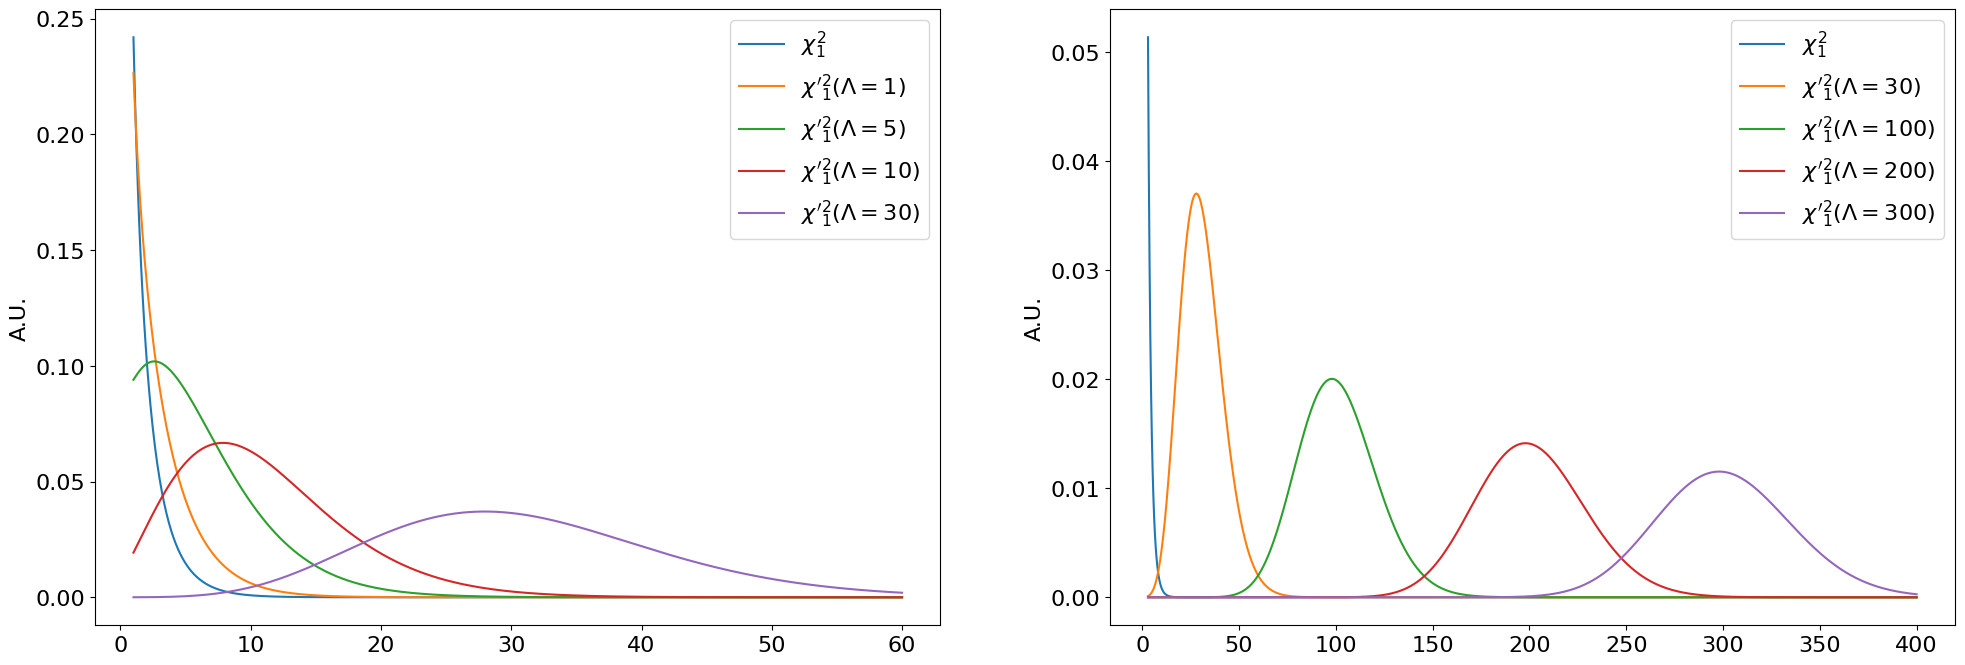

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

Lambdas = [[0, 1, 5, 10, 30], [0, 30, 100, 200, 300]]
xlims = [[1, 60], [3, 400]]

for i in range(2):
    x = np.linspace(*xlims[i], 1001)
    ax = axs[i]
    for l in Lambdas[i]:
        if l == 0:
            ax.plot(x, chi2.pdf(x, 1), label=r"$\chi^2_1$")
        else:
            ax.plot(x, ncx2.pdf(x, 1, l), label=rf"$\chi'^2_1(\Lambda = {l})$")

    ax.set_ylabel("A.U.")
    ax.legend()

plt.show()

## Estimating $\sigma_{\hat\mu}^2$

```{margin}
More generally, we'd need $\tilde{\mathcal I}^{-1}$ for Eq. {eq}`6Lambdamultipois`.
```

The critical remaining step to understanding the asymptotic form of $t_\mu$ is estimating $\sigma_{\hat\mu}^2$ to find the non-centrality parameter $\Lambda$ in Eq. {eq}`6Lambda`.
We'll now go over two methods to this.

### Method 1: Inverting the Fisher information / covariance matrix

The first method is simply using $\sigma_{\hat\mu} \simeq \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')}$ as in Part 5.
Let's see what this looks like for our counting experiment, using the analytic form for $\sigma_{\hat\mu}$ from Eq. {eq}`5asymstd`:

In [23]:
def plot_p_tmu(lambda_fn):
    num_toys = 30000
    s, b = 30, 10
    mus = [0, 1]  # , 1.0, 10.0]
    muprimes = [
        [0, 0.3, 0.6, 1],
        [0, 0.3, 0.6, 1],
    ]

    fig, axs = plt.subplots(1, 3, figsize=(32, 8))
    colours = ["blue", "orange", "green", "red"]

    xmaxs = [40, 80]

    for i, (mu, muprimes) in enumerate(zip(mus, muprimes)):
        axs[i].set_title(rf"Testing $\mu={mu}$ ($s = {s}, b = {b}$)")
        xmax = xmaxs[i]
        for j, muprime in enumerate(muprimes):
            # sample n, m according to our data model (Eq. 1)
            n, m = poisson.rvs(s * muprime + b, size=num_toys), poisson.rvs(b, size=num_toys)
            axs[i].hist(
                t_s(s * mu, n, m),
                np.linspace(0, xmax, 41),
                histtype="step",
                density=True,
                label=rf"$\mu'={muprime}$",
                color=colours[j],
            )

            x = np.linspace(xmax / 160, xmax, 101)

            if mu == muprime:
                axs[i].plot(
                    x, chi2.pdf(x, 1), label=r"$\chi^2_1$", color=colours[j], linestyle="--"
                )
            else:
                l = lambda_fn(mu, muprime, s, b)
                axs[i].plot(
                    x,
                    ncx2.pdf(x, 1, l),
                    label=rf"$\chi'^2_1(\Lambda = {l:.1f})$",
                    color=colours[j],
                    linestyle="--",
                )

        axs[i].legend()
        axs[i].set_xlabel(r"$t_\mu$")
        axs[i].set_ylabel(r"$p(t_\mu|\mu')$")

    i = 2
    sbmumups = [(300, 100, 1, 0), (20, 10, 3, 0), (10, 10, 1, 30)]
    xmax = 600

    for j, (s, b, mu, muprime) in enumerate(sbmumups):
        # sample n, m according to our data model (Eq. 1)
        n, m = poisson.rvs(s * muprime + b, size=num_toys), poisson.rvs(b, size=num_toys)
        axs[i].hist(
            t_s(s * mu, n, m),
            np.linspace(0, xmax, 41),
            histtype="step",
            density=True,
            label=rf"$s = {s}, b = {b}, \mu = {mu}, \mu'={muprime}$",
            color=colours[j],
        )

        x = np.linspace(xmax / 160, xmax, 101)

        if mu == muprime:
            axs[i].plot(x, chi2.pdf(x, 1), label=r"$\chi^2_1$", color=colours[j], linestyle="--")
        else:
            l = lambda_fn(mu, muprime, s, b)
            axs[i].plot(
                x,
                ncx2.pdf(x, 1, l),
                label=rf"$\chi'^2_1(\Lambda = {l:.1f})$",
                color=colours[j],
                linestyle="--",
            )

    axs[i].set_ylim(0, 0.03)
    axs[i].legend()
    axs[i].set_xlabel(r"$t_\mu$")
    axs[i].set_ylabel(r"$p(t_\mu|\mu')$")

    plt.show()

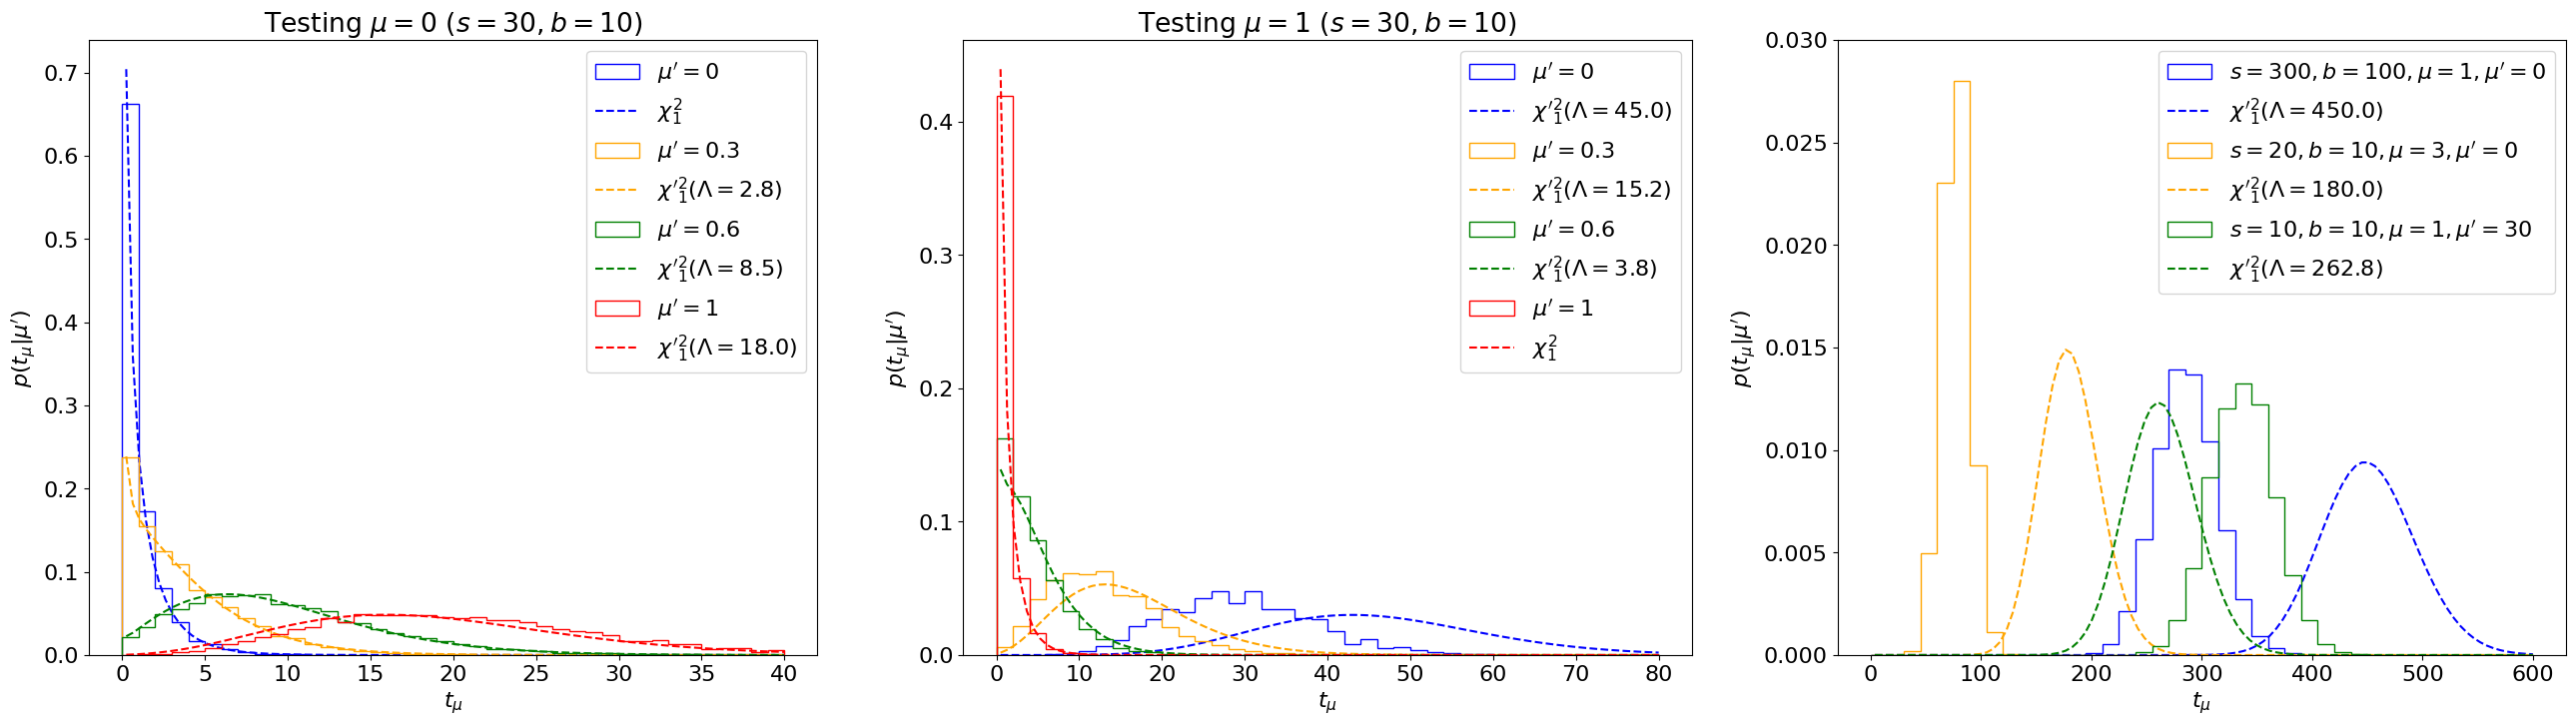

In [24]:
def LambdaFisher(mu, muprime, s, b):
    """Non-centrality parameter of the asymptotic non-central chi-squared distribution of p(t_mu)"""
    return np.power((mu - muprime) / get_asym_std(muprime, s, b), 2)


plot_p_tmu(LambdaFisher)

We can see that the estimate 

As discussed in Part {ref}`5.6 <5numerical_estimation>`, while we are able to find the analytic form for this for our simple counting experiment (Eq. {eq}`5asymstd`), in general the Fisher information matrix (Eq. {eq}`6fisher_matrix`) has to be calculated numerically.

### Method 2 Asimov Sigma

Another method is to recognize that for the Asimov dataset assuming $\mu', b'$, the MLEs $\hat\mu = \mu'$, $\hat b=b'$. 
E.g. from Eq. {eq}`mles`:

$$
    \hat b = m = b', \hat s = n - m = \mu' + b - b = \mu'.
$$ (6asimov_mles)

Thus, $t_\mu$ evaluated for the Asimov dataset

$$
    t_{\mu, A} \simeq \bigg (\frac{\mu-\hat\mu}{\sigma_{\hat\mu}}\bigg)^2 = \bigg (\frac{\mu-\mu'}{\sigma_{\hat\mu}}\bigg)^2 = \Lambda.
$$ (6asimov_mles)



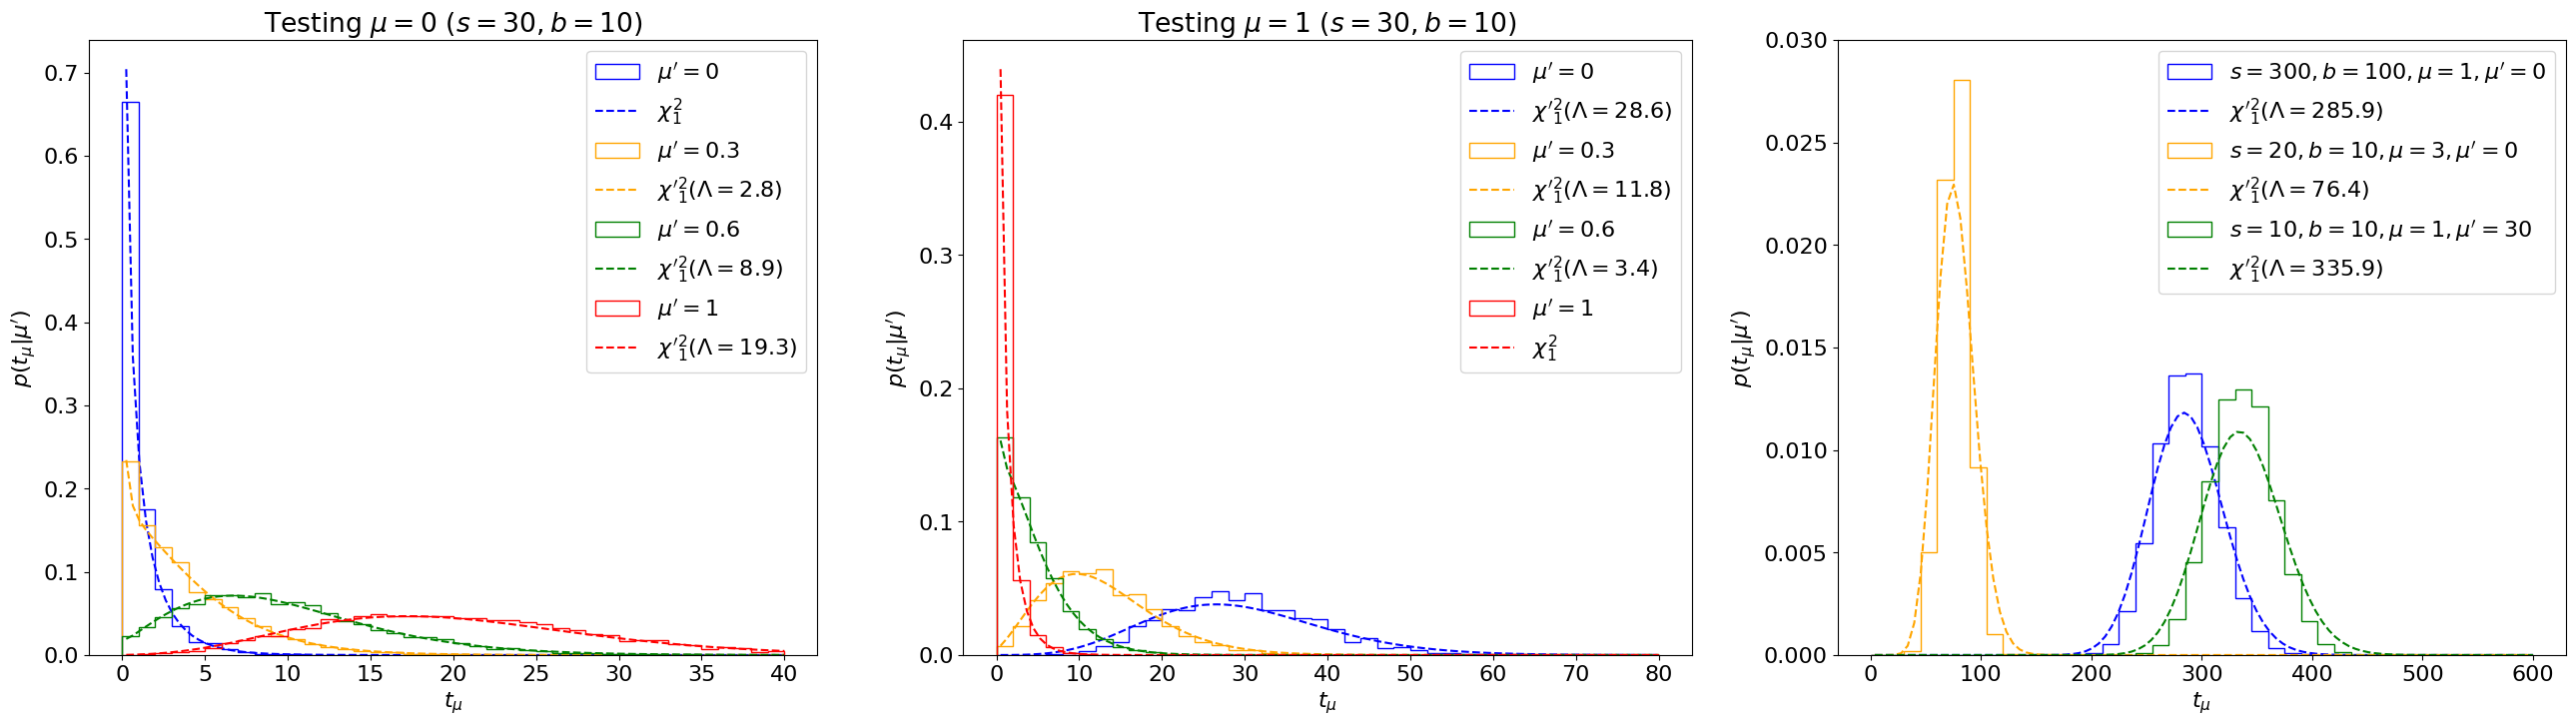

In [25]:
def LambdaA(mu, muprime, s, bprime):
    """Returns the test statistic for observations n = E[n] = µ's + b', m = E[m] = b'"""
    return t_s(s * mu, s * muprime + bprime, bprime)


plot_p_tmu(LambdaA)